### Statistical EDA & Data Cleaning

#### Phase 1, Part 1: The Sensor Audit (Variance Filtering)

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

# Define the data path relative to your notebook
data_path = os.path.join('CMaps', 'train_FD001.txt')

# Column names as per documentation
index_names = ['unit', 'cycle']
setting_names = ['os1', 'os2', 'os3']
sensor_names = [f's{i}' for i in range(1, 22)]
col_names = index_names + setting_names + sensor_names

# Load the dataset
# FD001 is space-delimited; use sep='\s+' to handle multiple spaces
df = pd.read_csv(data_path, sep='\s+', header=None, names=col_names)

print(f"Dataset loaded. Shape: {df.shape}")
df.head()

Dataset loaded. Shape: (20631, 26)


,unit,cycle,os1,os2,os3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 26 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   unit    20631 non-null  int64  
 1   cycle   20631 non-null  int64  
 2   os1     20631 non-null  float64
 3   os2     20631 non-null  float64
 4   os3     20631 non-null  float64
 5   s1      20631 non-null  float64
 6   s2      20631 non-null  float64
 7   s3      20631 non-null  float64
 8   s4      20631 non-null  float64
 9   s5      20631 non-null  float64
 10  s6      20631 non-null  float64
 11  s7      20631 non-null  float64
 12  s8      20631 non-null  float64
 13  s9      20631 non-null  float64
 14  s10     20631 non-null  float64
 15  s11     20631 non-null  float64
 16  s12     20631 non-null  float64
 17  s13     20631 non-null  float64
 18  s14     20631 non-null  float64
 19  s15     20631 non-null  float64
 20  s16     20631 non-null  float64
 21  s17     20631 non-null  int64  
 22

In [3]:
df.columns

Index(['unit', 'cycle', 'os1', 'os2', 'os3', 's1', 's2', 's3', 's4', 's5',
       's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16',
       's17', 's18', 's19', 's20', 's21'],
      dtype='object')

### Phase 1, Statistical EDA & Data Cleaning

#### Phase 1, Part 1: The Sensor Audit (Variance Check)

In [4]:
# Calculate standard deviation for all sensors
sensor_std = df[sensor_names].std()

# Identify sensors with near-zero variance
zero_variance_sensors = sensor_std[sensor_std < 0.001].index.tolist()

print(f"Sensors to drop (No variation): {zero_variance_sensors}")

# Drop them + os3 (which is also typically constant in FD001)
df_dropped = df.drop(columns=zero_variance_sensors + ['os3'])

# Update our active sensor list
active_sensors = [s for s in sensor_names if s not in zero_variance_sensors]

Sensors to drop (No variation): ['s1', 's5', 's10', 's16', 's18', 's19']


#### Part 2: Visualizing the "Healthy vs. Failing" States
**Part 2a: Calculating Rolling ADF p-values**

In [5]:
# Isolate Engine #1 for the statistical health-check
unit1 = df[df['unit'] == 1].copy()

from statsmodels.tsa.stattools import adfuller

# 1. Configuration
window_size = 30
p_values = []
cycles = unit1['cycle'].values

# 2. Sliding Window Loop
# We start from 'window_size' so the ADF test has enough data points to run
for i in range(window_size, len(unit1)):
    window_data = unit1['s11'].iloc[i-window_size:i]
    
    # Run ADF test and grab the p-value (index 1 of the result)
    result = adfuller(window_data)
    p_values.append(result[1])

# Pad the beginning with NaNs so the p_values array matches the length of the cycles
p_values_full = [np.nan] * window_size + p_values

# 3. Identify the "Statistical Change Point"
# Find the first cycle where p-value > 0.05
change_point = None
for idx, p in enumerate(p_values_full):
    if p > 0.05:
        change_point = cycles[idx]
        break

print(f"Statistical Change Point (ADF p > 0.05) detected at Cycle: {change_point}")

Statistical Change Point (ADF p > 0.05) detected at Cycle: 34


**Part 2b: Visualizing the Statistical Transition**

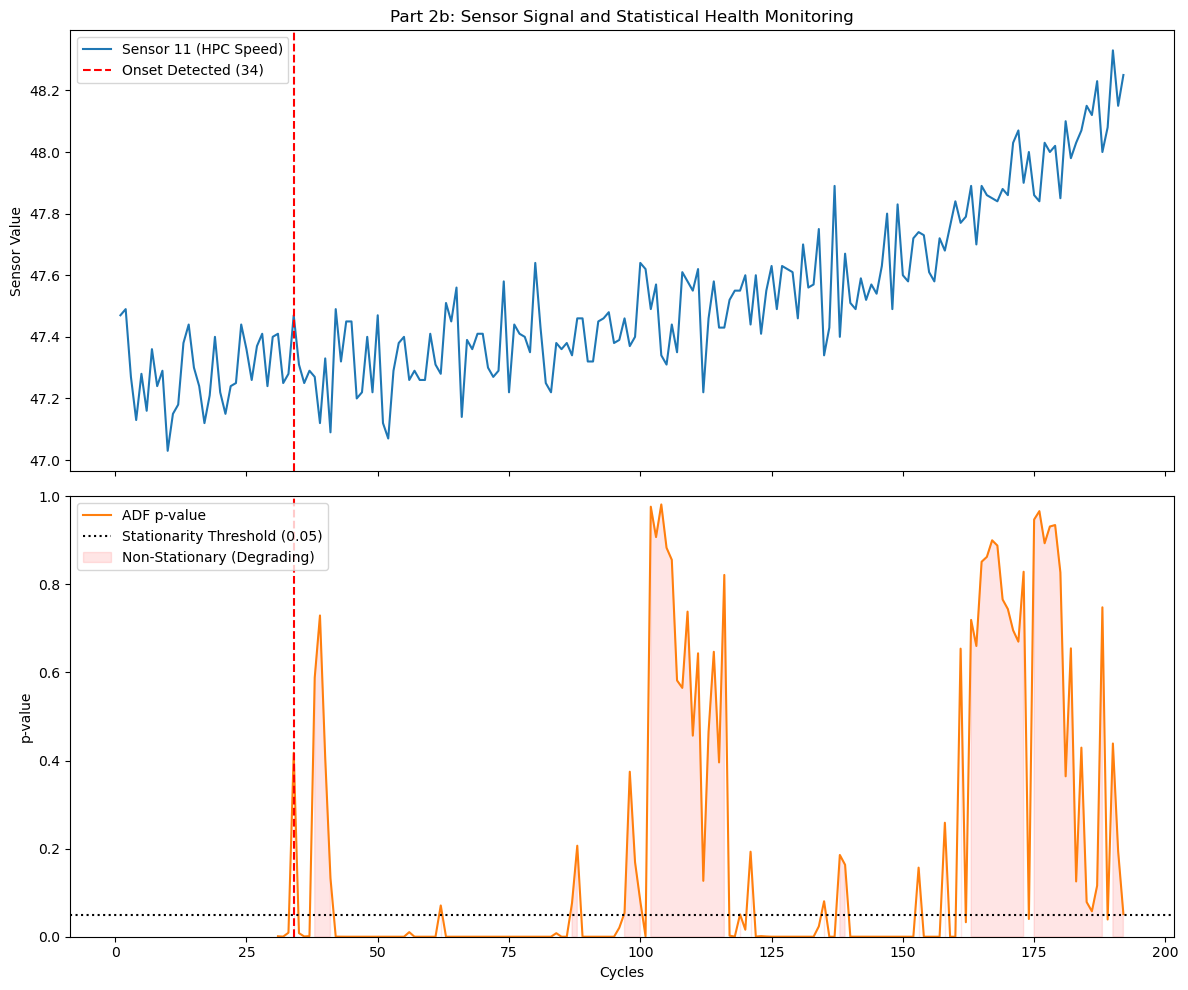

In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Top Plot: Raw Sensor Data
ax1.plot(cycles, unit1['s11'], color='tab:blue', label='Sensor 11 (HPC Speed)')
if change_point:
    ax1.axvline(x=change_point, color='red', linestyle='--', label=f'Onset Detected ({change_point})')
ax1.set_title('Part 2b: Sensor Signal and Statistical Health Monitoring')
ax1.set_ylabel('Sensor Value')
ax1.legend()

# Bottom Plot: ADF P-Value
ax2.plot(cycles, p_values_full, color='tab:orange', label='ADF p-value')
ax2.axhline(y=0.05, color='black', linestyle=':', label='Stationarity Threshold (0.05)')
if change_point:
    ax2.axvline(x=change_point, color='red', linestyle='--')
    ax2.fill_between(cycles, 0, p_values_full, where=(np.array(p_values_full) > 0.05), 
                     color='red', alpha=0.1, label='Non-Stationary (Degrading)')

ax2.set_ylabel('p-value')
ax2.set_xlabel('Cycles')
ax2.set_ylim(0, 1) # p-values are always between 0 and 1
ax2.legend()

plt.tight_layout()
plt.show()

#### Part 2c: Adding the Persistence Filter

In [8]:
# Part 2c: Refined Detection (Sustained Non-Stationarity)
persistence_window = 10  # Must be non-stationary for 10 cycles in a row
refined_change_point = None

counter = 0
for idx, p in enumerate(p_values_full):
    if p > 0.05:
        counter += 1
    else:
        counter = 0 # Reset if it drops back below 0.05
    
    if counter >= persistence_window:
        # Subtract persistence to get the start of the trend
        refined_change_point = cycles[idx - persistence_window + 1]
        break

print(f"Refined Statistical Change Point (Sustained): {refined_change_point}")

Refined Statistical Change Point (Sustained): 102


#### # Part 2d: Final Visualization of Refined Onset

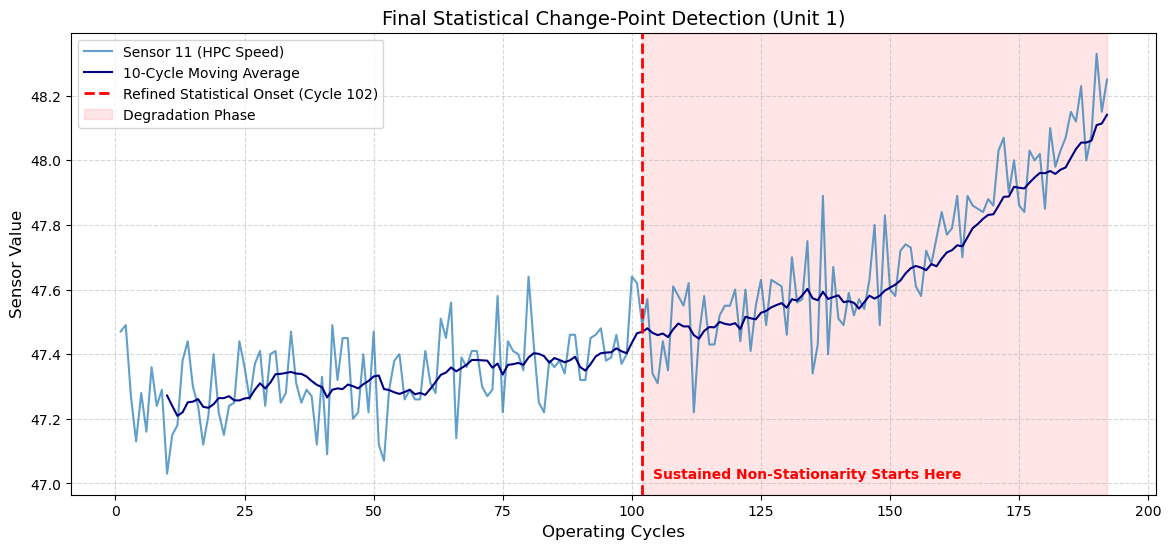

In [9]:
plt.figure(figsize=(14, 6))

# Plot the raw sensor data
plt.plot(unit1['cycle'], unit1['s11'], color='tab:blue', alpha=0.7, label='Sensor 11 (HPC Speed)')

# Plot a moving average just to help the eye see the trend you've mathematically found
smoothed_trend = unit1['s11'].rolling(window=10).mean()
plt.plot(unit1['cycle'], smoothed_trend, color='navy', linestyle='-', label='10-Cycle Moving Average')

# Add the Refined Change Point Line
if refined_change_point:
    plt.axvline(x=refined_change_point, color='red', linestyle='--', linewidth=2, 
                label=f'Refined Statistical Onset (Cycle {int(refined_change_point)})')
    
    # Highlight the Degradation Zone
    plt.axvspan(refined_change_point, unit1['cycle'].max(), color='red', alpha=0.1, label='Degradation Phase')

# Formatting for a Professional Portfolio
plt.title('Final Statistical Change-Point Detection (Unit 1)', fontsize=14)
plt.xlabel('Operating Cycles', fontsize=12)
plt.ylabel('Sensor Value', fontsize=12)
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend(loc='upper left')

# Add a text annotation explaining the logic
plt.text(refined_change_point + 2, plt.ylim()[0] + 0.05, 
         'Sustained Non-Stationarity Starts Here', color='red', fontweight='bold')

plt.show()

### Phase 2: Feature Engineering

#### Phase 2, Part 1: Rolling Feature Function

In [10]:
def add_rolling_features(df, sensor_list, window_size=20):
    """
    Calculates rolling mean and standard deviation for each sensor,
    grouped by engine unit to prevent data leakage between different engines.
    """
    # Create a copy to avoid SettingWithCopy warnings
    df_feat = df.copy()
    
    for sensor in sensor_list:
        # Calculate Rolling Mean
        mean_col_name = f'{sensor}_rolling_mean'
        df_feat[mean_col_name] = df_feat.groupby('unit')[sensor].transform(
            lambda x: x.rolling(window=window_size, min_periods=1).mean()
        )
        
        # Calculate Rolling Standard Deviation (captures instability/vibration)
        std_col_name = f'{sensor}_rolling_std'
        df_feat[std_col_name] = df_feat.groupby('unit')[sensor].transform(
            lambda x: x.rolling(window=window_size, min_periods=1).std()
        ).fillna(0) # Fill first row NaN with 0 since std requires 2 points
        
    return df_feat

# Execution: Apply to all active sensors identified in Phase 1
# We'll use a window of 20 as a balanced 'mid-range' capture
df_rolling = add_rolling_features(df_dropped, active_sensors, window_size=20)

print(f"New shape with rolling features: {df_rolling.shape}")
print("New columns added:")
print([col for col in df_rolling.columns if 'rolling' in col][:6]) # Show first 6 new columns

New shape with rolling features: (20631, 49)
New columns added:
['s2_rolling_mean', 's2_rolling_std', 's3_rolling_mean', 's3_rolling_std', 's4_rolling_mean', 's4_rolling_std']


#### Phase 2, Part 2: Lagged Features (The "Memory" Effect)

Lagged Features allow the model to compare:Current State: <br>
Where the engine is now.Past State: Where the engine was $N$ cycles ago. <br>
Why Lags are Important for Maintenance
If Sensor 11 is at 48.2, is that bad?

If it was 48.1 five cycles ago, it's a slow rise.

If it was 47.0 five cycles ago, the engine is failing rapidly. The model needs the lag feature to calculate this difference internally.

In [15]:
def add_lag_features(df, sensor_list, lag_size=5):
    """
    Creates 'Memory' features by shifting sensor values forward.
    This allows the model to see the trend direction (Delta).
    """
    df_feat = df.copy()
    
    for sensor in sensor_list:
        lag_col_name = f'{sensor}_lag_{lag_size}'
        # Group by unit to ensure Engine 2 doesn't see the end of Engine 1
        df_feat[lag_col_name] = df_feat.groupby('unit')[sensor].shift(lag_size)
        
        # We fill NaNs with the first available value for that unit 
        # so we don't lose the beginning of the engine's life.
        df_feat[lag_col_name] = df_feat[lag_col_name].fillna(method='bfill')
        
    return df_feat

# Execution: Let's look back 5 cycles
df_final_features = add_lag_features(df_rolling, active_sensors, lag_size=5)

print(f"Total Features now: {len(df_final_features.columns)}")
print("Sample Lag Columns:")
print([col for col in df_final_features.columns if 'lag' in col][:3])

Total Features now: 64
Sample Lag Columns:
['s2_lag_5', 's3_lag_5', 's4_lag_5']


#### Phase 2, Part 3: The Labeling Function (Piecewise RUL)

In [16]:
def add_piecewise_rul(df, max_rul=125):
    """
    Calculates the Remaining Useful Life (RUL) for each unit.
    Capping the RUL at max_rul (Piecewise Linear) helps the model 
    focus on the degradation phase rather than healthy noise.
    """
    # 1. Calculate the absolute Max Cycle for each unit
    # (The day the engine actually failed)
    max_cycle = df.groupby('unit')['cycle'].transform('max')
    
    # 2. Calculate actual RUL (Distance to failure)
    df['actual_rul'] = max_cycle - df['cycle']
    
    # 3. Apply the Piecewise 'Cap'
    # If RUL > 125, set it to 125. Otherwise, keep the actual countdown.
    df['label_rul'] = df['actual_rul'].clip(upper=max_rul)
    
    return df

# Execution: Apply the labeling to our dataframe
df_final = add_piecewise_rul(df_final_features, max_rul=125)

# Verify the labeling for Unit 1
unit1_labels = df_final[df_final['unit'] == 1][['cycle', 'actual_rul', 'label_rul']]
print("End of life for Unit 1 (Last 5 rows):")
print(unit1_labels.tail())

End of life for Unit 1 (Last 5 rows):
     cycle  actual_rul  label_rul
187    188           4          4
188    189           3          3
189    190           2          2
190    191           1          1
191    192           0          0


#### Phase 2, Part 4: Feature Correlation Audit

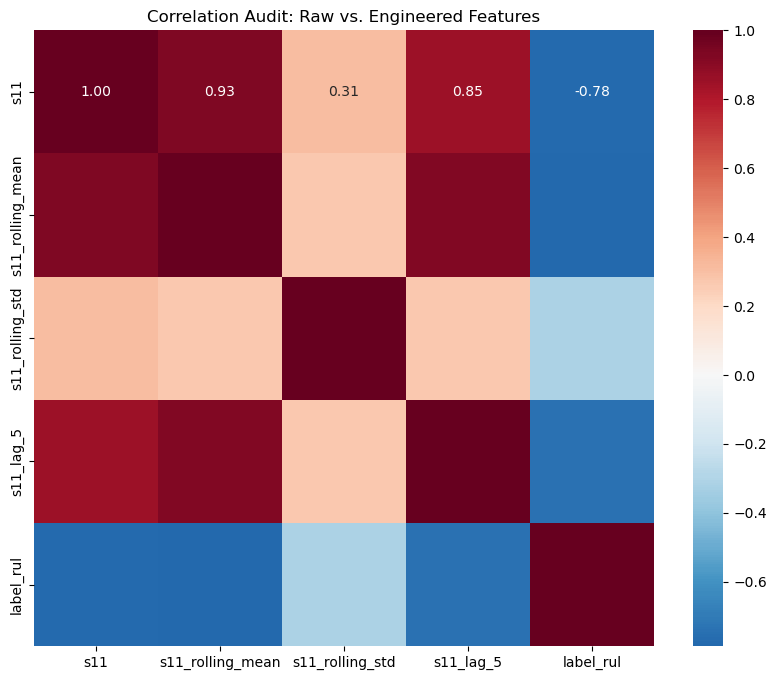

In [17]:
import seaborn as sns

# 1. Select a subset of features to keep the heatmap readable
# We'll compare raw s11, its rolling mean, and its lag against the label
audit_features = ['s11', 's11_rolling_mean', 's11_rolling_std', 's11_lag_5', 'label_rul']
corr_matrix = df_final[audit_features].corr()

# 2. Plotting the Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, fmt='.2f')
plt.title('Correlation Audit: Raw vs. Engineered Features')
plt.show()

In [18]:
# Save the final engineered dataframe to a CSV
df_final.to_csv('engineered_predictive_maintenance_data.csv', index=False)

print("Checkpoint successful: 'engineered_predictive_maintenance_data.csv' saved.")

Checkpoint successful: 'engineered_predictive_maintenance_data.csv' saved.


### Phase 3: Model Training

#### Pase 3 part 1: The Engine-Wise Split

In [19]:
import numpy as np

# 1. Identify all unique engines
all_units = df_final['unit'].unique()

# 2. Randomly select 80% for training, keep 20% for the "Final Exam"
np.random.seed(42) 
train_units = np.random.choice(all_units, size=int(0.8 * len(all_units)), replace=False)
test_units = np.setdiff1d(all_units, train_units)

# 3. Create the Training and Testing Dataframes
train_df = df_final[df_final['unit'].isin(train_units)].copy()
test_df = df_final[df_final['unit'].isin(test_units)].copy()

print(f"Training Engines: {len(train_units)} | Testing Engines: {len(test_units)}")

Training Engines: 80 | Testing Engines: 20


#### Pase 3 part 2: Defining the Input ($X$) and Target ($y$)

In [20]:
# Select only the active sensors and the engineered features
features = [col for col in df_final.columns if 'rolling' in col or 'lag' in col]
# Add back the raw active sensors (if they aren't already covered)
features += [s for s in active_sensors if s not in features]

X_train = train_df[features]
y_train = train_df['label_rul']

X_test = test_df[features]
y_test = test_df['label_rul']

#### Pase 3 part 3: Training the XGBoost Regressor

In [21]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Initialize the model
# Using 'squarederror' because we want to minimize the distance between predicted and actual RUL
model = XGBRegressor(
    n_estimators=100, 
    learning_rate=0.05, 
    max_depth=5, 
    random_state=42,
    n_jobs=-1 # Uses all your CPU cores for speed
)

# Fit the model
model.fit(X_train, y_train)

# Make Predictions
preds = model.predict(X_test)

#### Phase 3, Part 4: The Performance Audit

--- Model Performance Report ---
Mean Absolute Error (MAE): 13.85 cycles
RMSE: 19.15
R2 Score: 0.79
--------------------------------


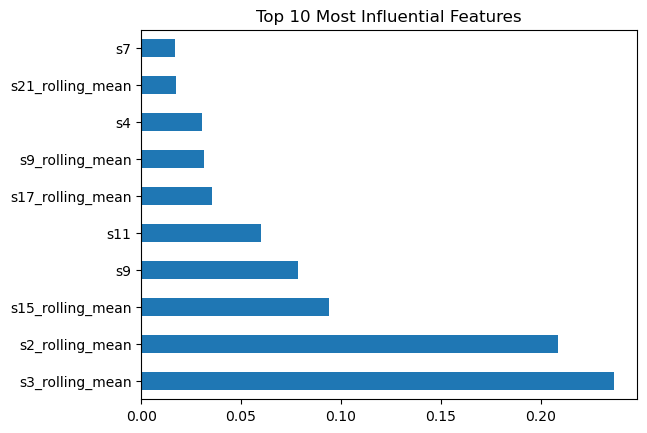

In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. Calculate Metrics
mae = mean_absolute_error(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))
r2 = r2_score(y_test, preds)

print(f"--- Model Performance Report ---")
print(f"Mean Absolute Error (MAE): {mae:.2f} cycles")
print(f"RMSE: {rmse:.2f}")
print(f"R2 Score: {r2:.2f}")
print(f"--------------------------------")

# 2. Check Feature Importance
import pandas as pd
import matplotlib.pyplot as plt

importances = pd.Series(model.feature_importances_, index=features)
importances.nlargest(10).plot(kind='barh')
plt.title("Top 10 Most Influential Features")
plt.show()

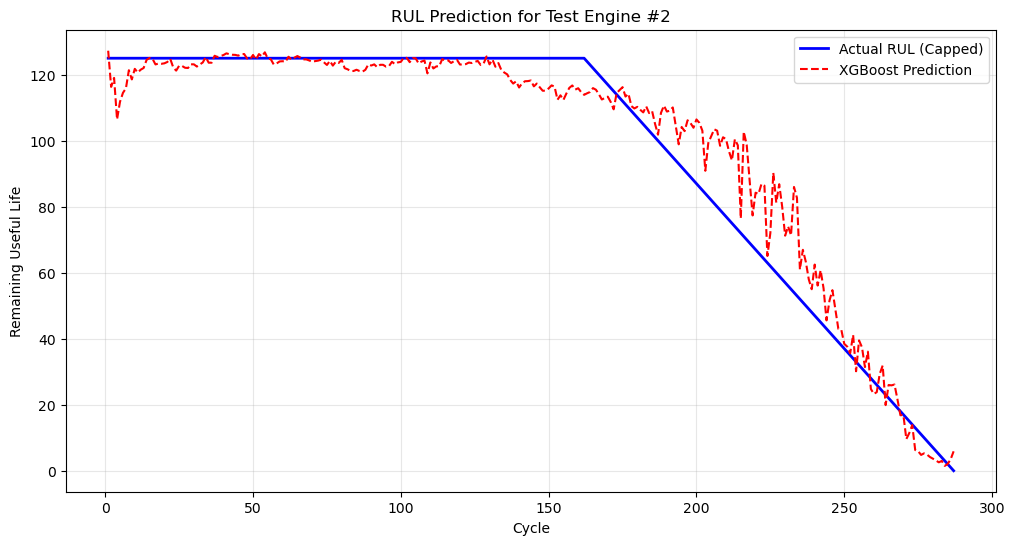

In [23]:
# 1. Pick an engine from the test set
sample_unit = test_units[0] 
sample_data = test_df[test_df['unit'] == sample_unit]

# 2. Get predictions for just this engine
sample_preds = model.predict(sample_data[features])

# 3. Plot the results
plt.figure(figsize=(12, 6))
plt.plot(sample_data['cycle'].values, sample_data['label_rul'].values, label='Actual RUL (Capped)', color='blue', linewidth=2)
plt.plot(sample_data['cycle'].values, sample_preds, label='XGBoost Prediction', color='red', linestyle='--')

plt.title(f"RUL Prediction for Test Engine #{sample_unit}")
plt.xlabel("Cycle")
plt.ylabel("Remaining Useful Life")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [24]:
# Save the model to a file
model.save_model('prophetic_maintenance_xgboost.json')

print("Model saved! You can now load this into any production system.")

TypeError: `_estimator_type` undefined.  Please use appropriate mixin to define estimator type.

In [25]:
import joblib

# Save the entire model object
joblib.dump(model, 'xgboost_predictive_model.pkl')

print("Model saved as a .pkl file!")

Model saved as a .pkl file!


### Phase 4, Part 1: Environment Setup and Model Loading

In [27]:
import pandas as pd
import numpy as np
import joblib
import os
from sklearn.metrics import mean_absolute_error

# 1. Define Column Names (Since .txt files have no header)
col_names = ['unit', 'cycle', 'os_1', 'os_2', 'os_3'] + [f's_{i}' for i in range(1, 22)]

# 2. Define File Paths
data_path = os.path.join('CMaps', 'test_FD001.txt')
rul_path = os.path.join('CMaps', 'RUL_FD001.txt')

# 3. Load the Files
# We use sep='\s+' because these files are space-delimited
df_test_raw = pd.read_csv(data_path, sep='\s+', header=None, names=col_names)
true_rul_val = pd.read_csv(rul_path, sep='\s+', header=None, names=['true_rul'])

# 4. Load your Pickled Model
loaded_model = joblib.load('xgboost_predictive_model.pkl')

print(f"Successfully loaded {len(df_test_raw)} rows of test data.")
print("Model reloaded from pickle.")

Successfully loaded 13096 rows of test data.
Model reloaded from pickle.


#### Phase 4, Part 2: Feature Engineering (The "Snapshot")

In [31]:
# 1. Update active sensors to match the naming in your error (e.g., 's2' not 's_2')
# Looking at your error, the model expects: 's2', 's3', 's4', 's6', 's7', etc.
active_sensors_prod = ['s2', 's3', 's4', 's6', 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20', 's21']

# 2. Rename columns in df_test_raw immediately to match the 's2' style
rename_dict = {f's_{i}': f's{i}' for i in range(1, 22)}
df_test_raw = df_test_raw.rename(columns=rename_dict)

def add_features_production(df, rolling_win_size=10):
    for col in active_sensors_prod:
        # Match 'sX_rolling_mean'
        df[f'{col}_rolling_mean'] = df.groupby('unit')[col].transform(lambda x: x.rolling(window=rolling_win_size).mean())
        # Match 'sX_rolling_std'
        df[f'{col}_rolling_std'] = df.groupby('unit')[col].transform(lambda x: x.rolling(window=rolling_win_size).std())
        # Match 'sX_lag_5' (The error says it wants lag_5, not lag_1)
        df[f'{col}_lag_5'] = df.groupby('unit')[col].shift(5)
    
    return df.fillna(method='bfill').fillna(method='ffill')

# Apply the corrected pipeline
df_test_processed = add_features_production(df_test_raw)

# Get the last cycle for each unit
df_test_last = df_test_processed.groupby('unit').last().reset_index()

#### Phase 4, Part 3: Final Production Metrics



In [32]:
# The model's required list of features
feature_cols = loaded_model.feature_names_in_

# Select the data
X_live = df_test_last[feature_cols]

# Predict
live_preds = loaded_model.predict(X_live)

# Create the final result table
results = pd.DataFrame({
    'Unit': df_test_last['unit'],
    'Predicted_RUL': live_preds,
    'Actual_RUL': true_rul_val['true_rul'].values
})

# Calculate Final Production MAE (Capping the actual RUL at 125 for fairness)
results['Actual_RUL_Capped'] = results['Actual_RUL'].clip(upper=125)
final_mae = mean_absolute_error(results['Actual_RUL_Capped'], results['Predicted_RUL'])

print(f"Success! Production MAE: {final_mae:.2f}")

Success! Production MAE: 13.76


In [33]:
# 1. Calculate the 'Error' for each prediction
results['Error'] = results['Predicted_RUL'] - results['Actual_RUL_Capped']

# 2. Sort by urgency (lowest Predicted RUL first)
risk_leaderboard = results.sort_values(by='Predicted_RUL').head(10)

print("--- TOP 10 URGENT MAINTENANCE TASKS ---")
print(risk_leaderboard[['Unit', 'Predicted_RUL', 'Actual_RUL', 'Error']].to_string(index=False))

--- TOP 10 URGENT MAINTENANCE TASKS ---
 Unit  Predicted_RUL  Actual_RUL     Error
   82       6.223863           9 -2.776137
   81       6.675589           8 -1.324411
   35       7.931759          11 -3.068241
   76       8.079845          10 -1.920155
   68      10.809254           8  2.809254
   34      11.268017           7  4.268017
   49      13.691301          21 -7.308699
   56      14.824775          15 -0.175225
   92      16.313545          20 -3.686455
   20      17.392481          16  1.392481


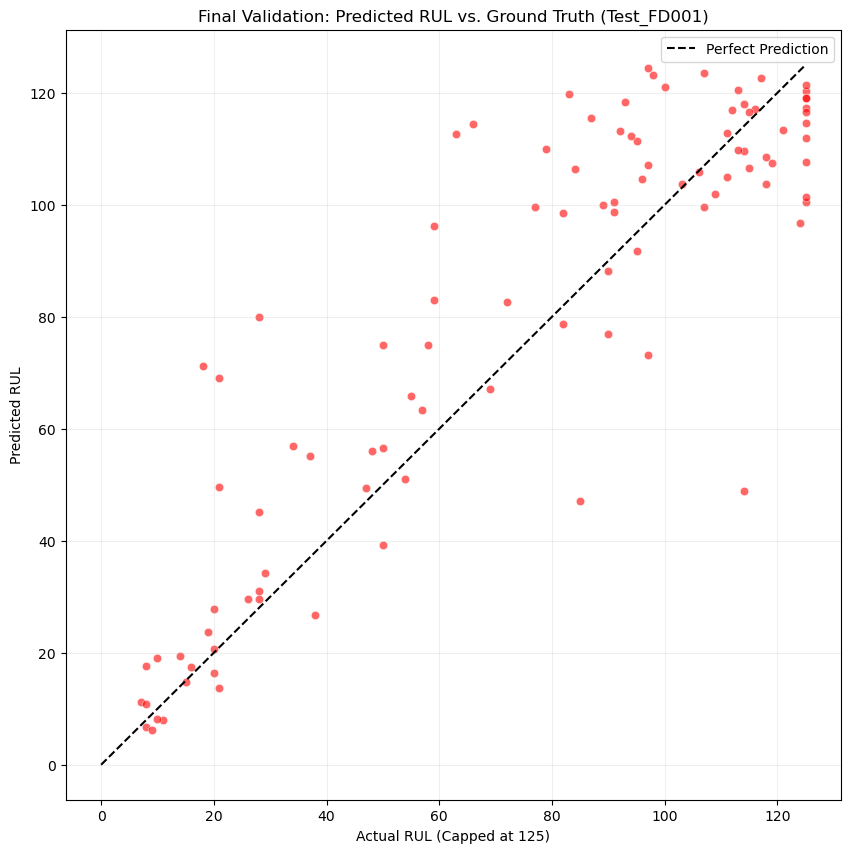

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 10))
# Plotting the identity line
plt.plot([0, 125], [0, 125], color='black', linestyle='--', label='Perfect Prediction')

# Plotting the results
sns.scatterplot(data=results, x='Actual_RUL_Capped', y='Predicted_RUL', alpha=0.6, color='red')

plt.title('Final Validation: Predicted RUL vs. Ground Truth (Test_FD001)')
plt.xlabel('Actual RUL (Capped at 125)')
plt.ylabel('Predicted RUL')
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()

### Phase 5: Sensitivity Analysis (The "Why" Factor)

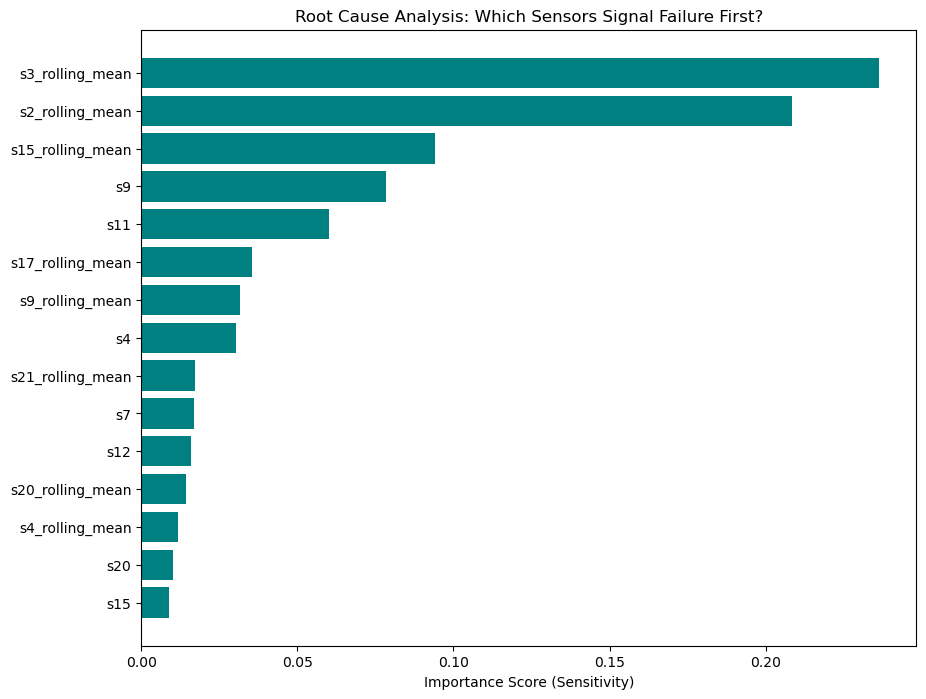

In [35]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. Get Feature Importances from the XGBoost model
importances = loaded_model.feature_importances_
feature_names = loaded_model.feature_names_in_

# 2. Create a DataFrame for easy visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 3. Plot the Top 15 "Red Flag" Features
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'].head(15), importance_df['Importance'].head(15), color='teal')
plt.gca().invert_yaxis()
plt.title('Root Cause Analysis: Which Sensors Signal Failure First?')
plt.xlabel('Importance Score (Sensitivity)')
plt.show()

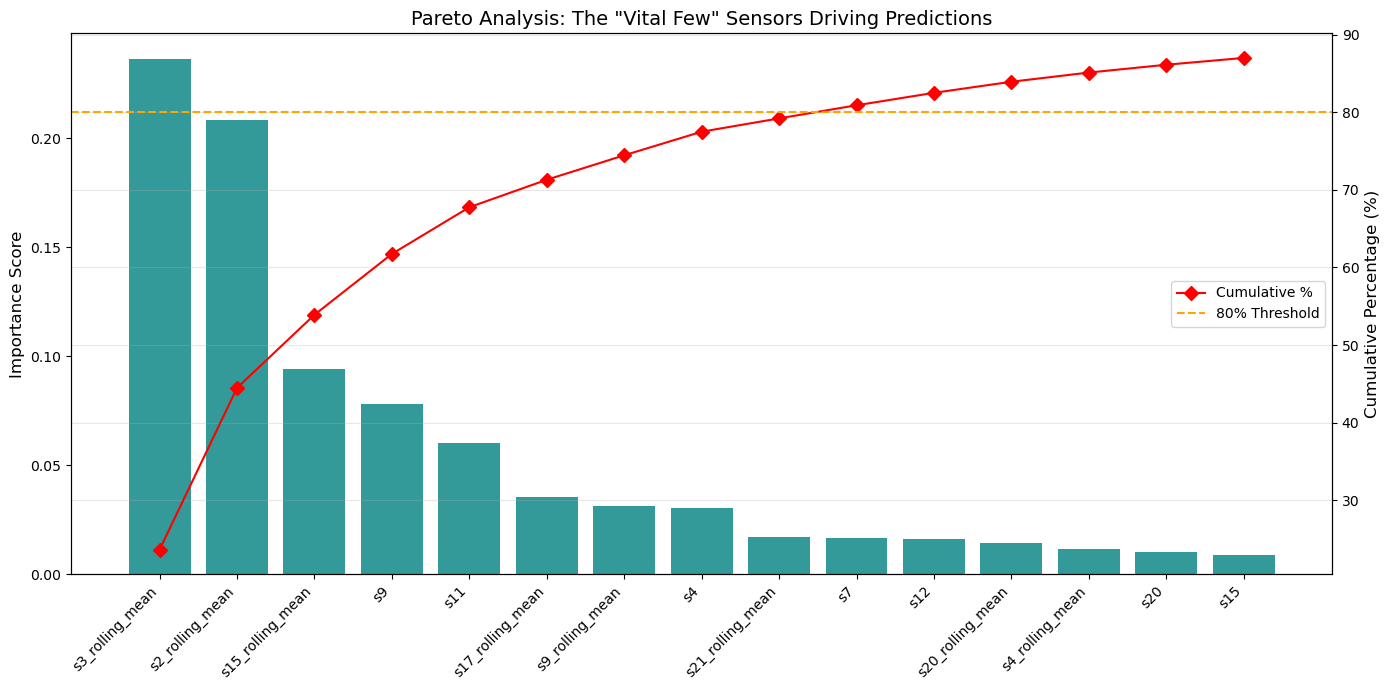

In [40]:
import matplotlib.pyplot as plt

# 1. Prepare Data
importance_df = pd.DataFrame({
    'Feature': loaded_model.feature_names_in_,
    'Importance': loaded_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

importance_df['cum_percentage'] = importance_df['Importance'].cumsum() / importance_df['Importance'].sum() * 100

# 2. Plotting
fig, ax1 = plt.subplots(figsize=(14, 7))

# Bar Chart
ax1.bar(importance_df['Feature'].head(15), importance_df['Importance'].head(15), color='teal', alpha=0.8)
ax1.set_ylabel('Importance Score', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Cumulative Line (Pareto)
ax2 = ax1.twinx()
ax2.plot(importance_df['Feature'].head(15), importance_df['cum_percentage'].head(15), 
         color='red', marker='D', ms=7, label='Cumulative %')
ax2.axhline(80, color='orange', linestyle='--', label='80% Threshold') # Pareto Line
ax2.set_ylabel('Cumulative Percentage (%)', fontsize=12)

plt.title('Pareto Analysis: The "Vital Few" Sensors Driving Predictions', fontsize=14)
ax2.legend(loc='center right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

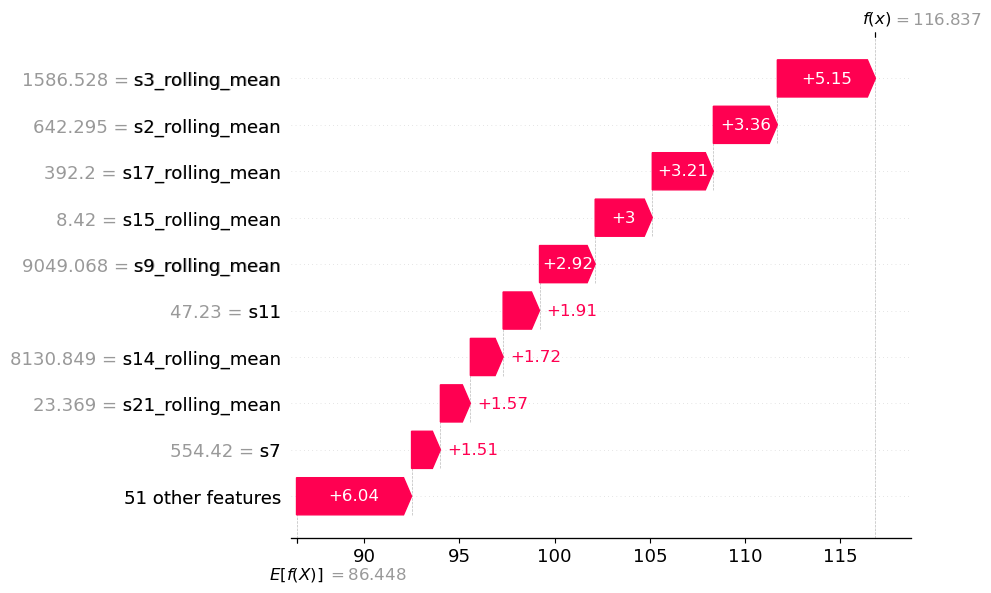

In [36]:
import shap

# Initialize the SHAP explainer with your loaded model
explainer = shap.TreeExplainer(loaded_model)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_live)

# Plot for a single engine (e.g., the first one in X_live)
# This will show how S3, S2, etc., specifically contributed to THAT prediction
shap.plots.waterfall(explainer(X_live)[0])